## 可加性模型測試 

In [61]:
library(splines)

### 使用資料:助教的爬蟲範例:以vix、vfx等5個指標預測S&P500

In [77]:
data=read.csv("測試資料.csv")
head(data)

Date,vix,vfx,vbx,rom,vmt,spx
2020-01-02,12.5,297,10.9,26.4,25.1,6609
2020-01-03,14.0,295,10.9,26.3,24.9,6563
2020-01-06,13.9,296,10.9,26.4,25.0,6587
2020-01-07,13.8,295,10.9,26.3,25.1,6569
2020-01-08,13.4,296,10.9,26.4,25.2,6601
2020-01-09,12.5,299,10.9,26.6,25.2,6647


#### 將S&P500資料全部往前挪一位(以今日5個金融指標預測明日S&P500)

In [54]:
date=data$Date[-1]
data$spx[1:nrow(data)-1]=data$spx[2:nrow(data)]
data=data[1:nrow(data)-1,]
data=data[,-1]
head(data)

vix,vfx,vbx,rom,vmt,spx
12.47,296.8520,10.89541,26.409,25.100,6563.32
14.02,294.7887,10.93474,26.303,24.910,6586.54
13.85,295.8253,10.92491,26.376,25.035,6568.74
13.79,295.0256,10.90524,26.290,25.090,6601.15
13.45,296.4867,10.88558,26.374,25.160,6646.84
12.54,298.5303,10.89541,26.565,25.233,6627.87


#### 遺漏值處理

[1] 1

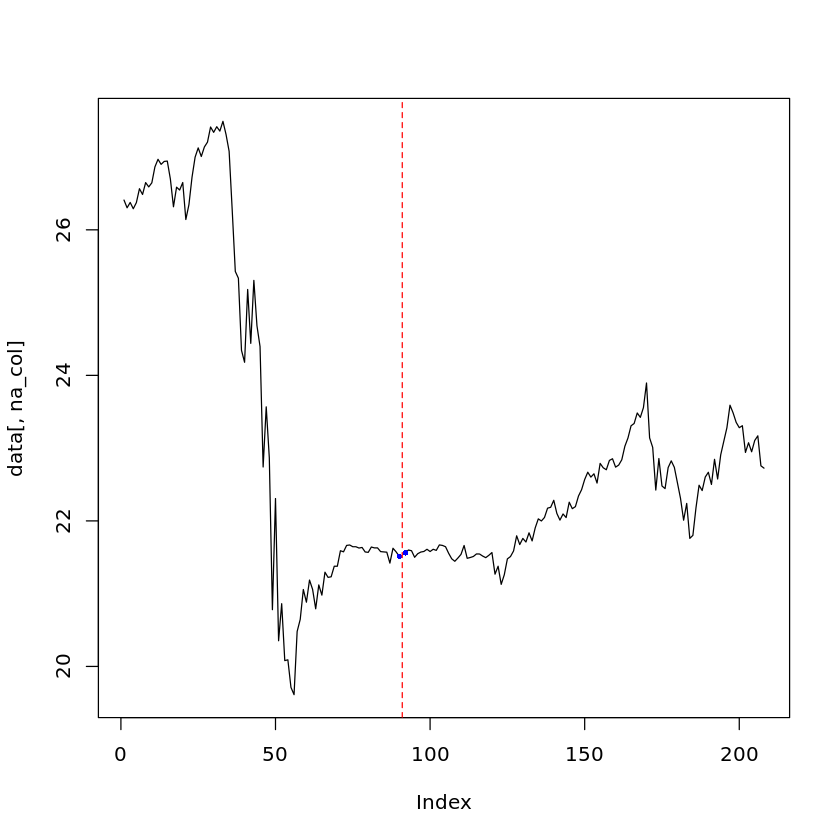

In [55]:
sum(is.na(data))
na_col=which(is.na(data))%/%nrow(data) +1
na_row=which(is.na(data))%%nrow(data)
if(na_row==0){na_row=nrow(data)}
plot(data[,na_col],type="l")
points(c(na_row-1,na_row+1),
       data[c(na_row-1,na_row+1),na_col],
       pch=16,col="blue",cex=0.6)
abline(v=na_row,lty=2,col=2)

In [56]:
#遺漏值位在相對平穩的區段，用前後值取平均補值
data[na_row,na_col]=mean(data[na_row-1,na_col],
                         data[na_row+1,na_col])

#### B-spline

In [ ]:
knot=function(x,lowbond,upperbond){
  if(x==0){return(NULL)}
  else{return(seq(lowbond,upperbond,by=(upperbond-lowbond)/(x+1))[c(-1,-(x+2))])}
}

In [ ]:
#Quadratic spline
order=3 
var_num=ncol(data)-1
Y=data$spx

In [38]:
#嘗試節點組合
kn=0:10
knotset=expand.grid(kn,kn,kn,kn,kn)

In [40]:
RSSCV=c()
for(N in 1:nrow(knotset)){
  basis=list()
  #基底矩陣
  for(var in 1:var_num){
    x=data[,var]
    low=min(x)
    up=max(x)
    B=bs(x,deg=order-1, knots=knot(knotset[N,var],low,up), Boundary.knots=c(low,up),intercept=F)
    basis[[var]]=B
  }
  #基底調整
  basismix=do.call(cbind,basis)
  basismix=cbind(rep(1,nrow(data)),basismix,Y)
  colnames(basismix)=c(paste("V",0:(ncol(basismix)-2),sep=""),"y")
  basismix=as.data.frame(basismix)
  #model
  model=lm(y~.-1,data=basismix)
  hii.v=lm.influence(model)$hat
  rsscv=mean((model$resid/(1-hii.v))^2)
  RSSCV[N]=rsscv
}

In [57]:
min(RSSCV)
bestset=which.min(RSSCV)
bestknot=knotset[bestset,]
bestknot=as.vector(as.matrix(bestknot))
#最佳節點組合
bestknot

[1] 14529.49

[1] 3 0 0 0 2

In [58]:
#用最佳節點執行B-spline近似

for(var in 1:var_num){
  x=data[,var]
  low=min(x)
  up=max(x)
  B=bs(x,deg=order-1, knots=knot(bestknot[var],low,up), Boundary.knots=c(low,up),intercept=F)
  basis[[var]]=B
}
#基底調整
basismix=do.call(cbind,basis)
basismix=cbind(rep(1,nrow(data)),basismix,Y)
colnames(basismix)=c(paste("V",0:(ncol(basismix)-2),sep=""),"y")
basismix=as.data.frame(basismix)
#model
model=lm(y~.-1,data=basismix)

#### leave one out CV

In [64]:
install.packages("DAAG")
library(DAAG)

also installing the dependencies ‘png’, ‘jpeg’, ‘latticeExtra’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: lattice


In [67]:
LOOCV=cv.lm(basismix,model,m=nrow(basismix),plotit = F)

Analysis of Variance Table

Response: y
           Df   Sum Sq  Mean Sq  F value  Pr(>F)    
V0          1 8.55e+09 8.55e+09 7.05e+05 < 2e-16 ***
V1          1 3.40e+07 3.40e+07 2.80e+03 < 2e-16 ***
V2          1 2.35e+06 2.35e+06 1.93e+02 < 2e-16 ***
V3          1 1.04e+07 1.04e+07 8.56e+02 < 2e-16 ***
V4          1 7.52e+06 7.52e+06 6.20e+02 < 2e-16 ***
V5          1 2.28e+06 2.28e+06 1.88e+02 < 2e-16 ***
V6          1 9.42e+06 9.42e+06 7.77e+02 < 2e-16 ***
V7          1 4.45e+06 4.45e+06 3.67e+02 < 2e-16 ***
V8          1 2.73e+04 2.73e+04 2.25e+00 0.13502    
V9          1 4.11e+05 4.11e+05 3.39e+01 2.4e-08 ***
V10         1 4.56e+02 4.56e+02 4.00e-02 0.84638    
V11         1 1.14e+03 1.14e+03 9.00e-02 0.75917    
V12         1 1.40e+05 1.40e+05 1.16e+01 0.00082 ***
V13         1 6.81e+02 6.81e+02 6.00e-02 0.81298    
V14         1 8.13e+04 8.13e+04 6.70e+00 0.01037 *  
V15         1 2.03e+05 2.03e+05 1.68e+01 6.3e-05 ***
Residuals 192 2.33e+06 1.21e+04                     
---
Si

In [66]:
head(LOOCV)

V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,y,Predicted,cvpred
1,0.0413,0.000220,0,0,0,0.389,0.541,0.269,0.0256,0.237,0.744,0,0.0425,0.456,0.502,6563,6644,6655
1,0.1998,0.005918,0,0,0,0.404,0.517,0.318,0.0394,0.256,0.721,0,0.0762,0.552,0.372,6587,6576,6575
1,0.1836,0.004917,0,0,0,0.397,0.529,0.307,0.0357,0.243,0.737,0,0.0529,0.492,0.455,6569,6582,6583
1,0.1778,0.004585,0,0,0,0.403,0.519,0.282,0.0288,0.258,0.718,0,0.0440,0.461,0.495,6601,6548,6543
1,0.1442,0.002926,0,0,0,0.392,0.536,0.255,0.0226,0.243,0.737,0,0.0339,0.419,0.547,6647,6552,6543
1,0.0489,0.000311,0,0,0,0.376,0.560,0.269,0.0256,0.207,0.779,0,0.0247,0.370,0.605,6628,6650,6652


In [69]:
library(ggplot2)
date=as.character(date)
str=function(string){
  mon=substring(string,6,7)
  day=substring(string,9,10)
  return(paste(mon,"/",day,sep=""))
}
date=str(date)

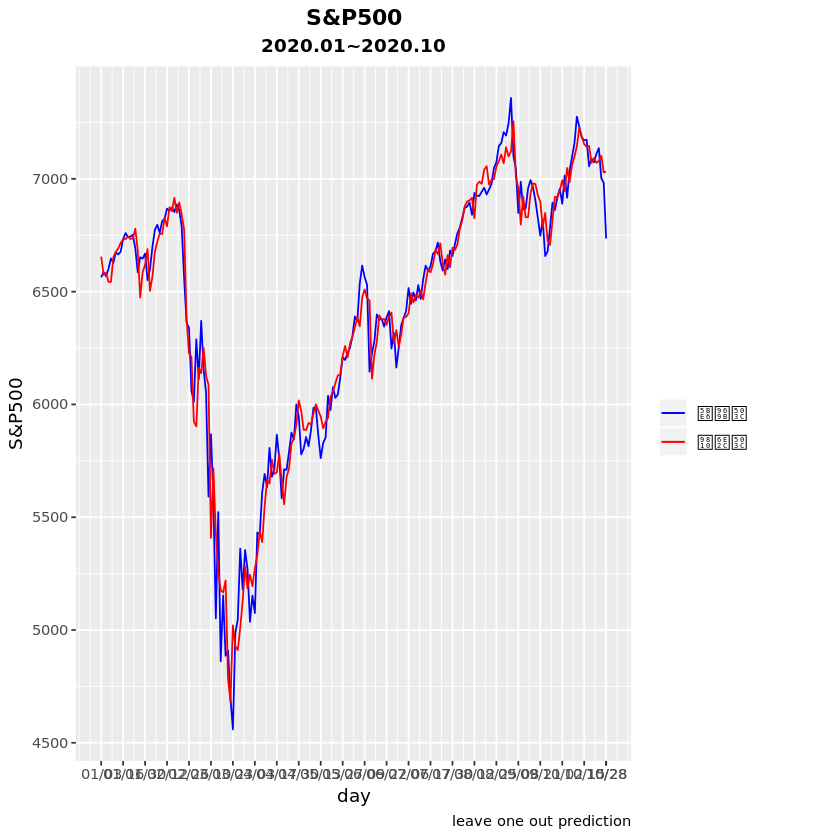

In [71]:
plotdata=data.frame(Date=1:length(Y),true=Y,Pred=LOOCV$cvpred)
ggplot(data=plotdata,aes(x=Date))+
  geom_line(aes(y=true,col="實際值"))+
  geom_line(aes(y=Pred,col="預測值"))+
  scale_x_continuous(breaks=c(seq(1,length(Y),9),length(Y)),
                     labels=date[c(seq(1,length(Y),9),length(Y))])+
  labs(x="day",y="S&P500",title="S&P500",
       subtitle="2020.01~2020.10",
       caption="leave one out prediction")+
  theme(plot.title=element_text(hjust = 0.5,face="bold"))+
  theme(plot.subtitle=element_text(hjust = 0.5,face="bold"))+
  scale_colour_manual(name = "",
                      values = c("Blue","red"))

#### 模型診斷

In [79]:
a1=paste("模型殘差     :",sqrt(mean((LOOCV$y-LOOCV$Predicted)^2)))
a2=paste("預測誤差     :",sqrt(mean((LOOCV$y-LOOCV$cvpred)^2)))
a3=paste("S&P500標準差 :",sd(Y))
cat(a1,a2,a3,sep="\n")

模型殘差     : 105.810991646943
預測誤差     : 120.538334803462
S&P500標準差 : 596.157044884812
